In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
import sys
import os
import torch
import torch.onnx
from torch.nn import functional as F
import numpy as np
from tqdm.notebook import tqdm
import re
import time
sys.path.insert(0, "../")
from models.hilcodec.streaming import HILCodec
from utils import get_hparams
from models import get_wrapper
import librosa
torch.set_num_threads(1)

base_dir = "../logs/hilcodec_speech"

hps = get_hparams(None, base_dir)
wrapper = get_wrapper(hps.model)(hps, train=False)
wrapper.load()
wrapper.eval()
SR = wrapper._module.sample_rate

assert hps.model_kwargs.pop("spec_learnable") == False
assert hps.model_kwargs.pop("causal") == True
assert hps.model_kwargs.pop("pad_mode") == 'constant'
model = HILCodec(SR, **hps.model_kwargs)
_ = model.eval()

Loading checkpoint file '../logs/hilcodec_speech/00150.pth'...


In [2]:
self, encoder = model.encoder, wrapper.model.encoder
self.conv_pre.load_state_dict(encoder.conv_pre[1].conv.conv.state_dict())
for self_resblocks, resblocks in zip(self.blocks, encoder.blocks):
    for self_resblock, resblock in zip(self_resblocks, resblocks):
        self_resblock.block[0].pointwise[1].load_state_dict(resblock.block[1].conv.conv.state_dict())
        self_resblock.block[0].depthwise.load_state_dict(resblock.block[2].conv.conv.state_dict())
        self_resblock.block[1].pointwise[1].load_state_dict(resblock.block[4].conv.conv.state_dict())
        self_resblock.block[1].depthwise.load_state_dict(resblock.block[5].conv.conv.state_dict())
        self_resblock.res_scale_param.data.copy_(resblock.res_scale_param.data)
    for self_specblock, specblock in zip(self.spec_blocks, encoder.spec_blocks):
        self_specblock.layer.load_state_dict(specblock.layer.conv.conv.state_dict())
        self_specblock.scale_param.data.copy_(specblock.scale_param.data)
    for self_downp, self_downd, down in zip(self.downsample_pointwise, self.downsample_depthwise, encoder.downsample):
        self_downp[1].load_state_dict(down[2].conv.conv.state_dict())
        self_downd.load_state_dict(down[3].conv.conv.state_dict())
self.spec_post.layer.load_state_dict(encoder.spec_post.layer.conv.conv.state_dict())
self.spec_post.scale_param.data.copy_(encoder.spec_post.scale_param.data)
self.conv_post_depthwise.load_state_dict(encoder.conv_post[1].conv.conv.state_dict())
self.conv_post_pointwise.load_state_dict(encoder.conv_post[2].conv.conv.state_dict())

self, decoder = model.decoder, wrapper.model.decoder.model
self.conv_pre_pointwise.load_state_dict(decoder[0].conv.conv.state_dict())
self.conv_pre_depthwise.load_state_dict(decoder[1].conv.conv.state_dict())
idx = 2
for up_depth, up_point, resblocks in zip(self.upsample_depthwise, self.upsample_pointwise, self.blocks):
    idx += 2    # scale & upsample_act
    up_depth.load_state_dict(decoder[idx].convtr.convtr.state_dict()); idx += 1
    up_point.load_state_dict(decoder[idx].conv.conv.state_dict()); idx += 1
    for resblock in resblocks:
        resblock.block[0].pointwise[1].load_state_dict(decoder[idx].block[1].conv.conv.state_dict())
        resblock.block[0].depthwise.load_state_dict(decoder[idx].block[2].conv.conv.state_dict())
        resblock.block[1].pointwise[1].load_state_dict(decoder[idx].block[4].conv.conv.state_dict())
        resblock.block[1].depthwise.load_state_dict(decoder[idx].block[5].conv.conv.state_dict())
        resblock.res_scale_param.data.copy_(decoder[idx].res_scale_param.data)
        idx += 1  # end of each resblock
idx += 2    # scale & upsample_act
self.conv_post.load_state_dict(decoder[idx].conv.conv.state_dict())

for vq1, vq2, vq3 in zip(model.quantizer.layers, model.dequantizer.layers, wrapper.model.quantizer.layers):
    vq1.embed.data.copy_(vq3.embed.data)
    vq1.ema_num.data.copy_(vq3.ema_num.data)
    vq2.embed.data.copy_(vq3.embed.data)
    vq2.ema_num.data.copy_(vq3.ema_num.data)

model.eval()
model.remove_weight_reparameterizations()
print("loaded!")

loaded!


In [3]:
cache_enc, cache_dec = model.initialize_cache(torch.randn(1))

hop_size = 320

wav = librosa.load("../onnx/input_speech.wav", sr=SR)[0][:SR*5]
wav = torch.from_numpy(wav).view(1,1,  -1).clamp(min=-1, max=1)
length = wav.size(-1) // hop_size * hop_size
wav = wav[:,:,:length]
wav_in = wav[:, :, :hop_size]
print("cache initialized!")

cache initialized!


Encoder:   0%|          | 0/375 [00:00<?, ?it/s]

Decoder:   0%|          | 0/375 [00:00<?, ?it/s]

enc_time: 3.1 sec / rtf: 1.6249028788437831 (↑)
dec_time: 8.8 sec / rtf: 0.5666245099605797 (↑)
total: 11.9 sec / rtf: 0.4201224233664302 (↑)


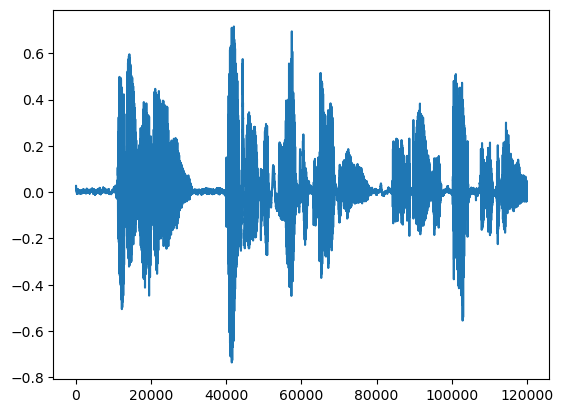

### In:

### Out:

In [4]:
wav_out_list = []
enc_time, dec_time = 0., 0.
indices_list = []
with torch.no_grad():
    st = time.perf_counter()
    for i in tqdm(range(0, length, hop_size), desc="Encoder"):
        wav_in = wav[:, :, i:i+hop_size]
        x, cache_enc = model.encoder(wav_in, *cache_enc)
        indices = model.quantizer(x, n=8)   # n: number of codebooks to use. 1 <= n <= hps.model_kwargs.vq_kwargs.num_quantizers
        indices_list.append(indices)
    et = time.perf_counter()
    enc_time += et - st
    st = et
    for indices in tqdm(indices_list, desc="Decoder"):
        q = model.dequantizer(indices, 8)
        wav_out, cache_dec = model.decoder(q, *cache_dec)
        wav_out_list.append(wav_out.squeeze(1))
    et = time.perf_counter()
    dec_time += et - st
    st = et

print(f"enc_time: {enc_time:.1f} sec / rtf: {length/SR / enc_time} (↑)")
print(f"dec_time: {dec_time:.1f} sec / rtf: {length/SR / dec_time} (↑)")
total = enc_time + dec_time
print(f"total: {total:.1f} sec / rtf: {length/SR / total} (↑)")

wav_out = torch.cat(wav_out_list, dim=1)
plt.plot(wav_out[0].numpy())
plt.show()
ipd.display(ipd.Markdown('### In:'), ipd.Audio(wav.numpy().squeeze(), rate=SR, normalize=False))
ipd.display(ipd.Markdown('### Out:'), ipd.Audio(wav_out[0].numpy(), rate=SR, normalize=False))
cache_enc, cache_dec = model.initialize_cache(torch.randn(1))

# Import each

In [6]:
cache_enc, cache_dec = model.initialize_cache(torch.randn(1))
NAME = "hil_speech"

### Encoder ###
dynamic_axes = dict(wav_in={0: 'batch', 2: 'time'})
dynamic_axes.update({f"e_in{i}": {0: "batch", 2:"time"} for i in range(len(cache_enc))})
dynamic_axes.update({f"e_out{i}": {0: "batch", 2:"time"} for i in range(len(cache_enc))})
torch.onnx.export(
    model.encoder,
    (wav_in, *cache_enc),
    f"../onnx/{NAME}_enc.onnx",
    input_names = ['wav_in'] + [f'e_in{i}' for i in range(len(cache_enc))],
    output_names = ['x'] + [f'e_out{i}' for i in range(len(cache_enc))],
    dynamic_axes = dynamic_axes,
    opset_version=17
)
cache_enc_dict = {f"e_in{i}": e.numpy() for i, e in enumerate(cache_enc)}
np.savez(f'../onnx/{NAME}_cache_enc.npz', **cache_enc_dict)

### Quantizer ###
for idx, vq in enumerate(model.quantizer.layers):
    torch.onnx.export(
        vq,
        (x,),
        f"../onnx/{NAME}_vq{idx}.onnx",
        input_names = ['x'],
        output_names = ['q', 'idx'],
        dynamic_axes={"x": {0: "batch", 1: "time"}}
    )

### Dequantizer ###
for idx, deq in enumerate(model.dequantizer.layers):
    torch.onnx.export(
        deq,
        (indices[0],),
        f"../onnx/{NAME}_deq{idx}.onnx",
        input_names = ['idx'],
        output_names = ['q'],
        dynamic_axes={"idx": {0: "batch", 1: "time"}}
    )

### Decoder ###
dynamic_axes = dict(q={0: 'batch', 1: 'time'})
dynamic_axes.update({f"d_in{i}": {0: "batch", 2:"time"} for i in range(len(cache_dec))})
dynamic_axes.update({f"d_out{i}": {0: "batch", 2:"time"} for i in range(len(cache_dec))})
torch.onnx.export(
    model.decoder,
    (x, *cache_dec),
    f"../onnx/{NAME}_dec.onnx",
    input_names = ['q'] + [f'd_in{i}' for i in range(len(cache_dec))],
    output_names = ['wav_out'] + [f'd_out{i}' for i in range(len(cache_dec))],
    dynamic_axes = dynamic_axes
)
cache_dec_dict = {f"d_in{i}": e.numpy() for i, e in enumerate(cache_dec)}
np.savez(f'../onnx/{NAME}_cache_dec.npz', **cache_dec_dict)
print("onnx ported!")

onnx ported!
